In [50]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from dateutil.relativedelta import relativedelta   # working with dates with style
from scipy.optimize import minimize                # for function minimization

import statsmodels.formula.api as smf               # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                      # some useful function
from tqdm import tqdm_notebook

%matplotlib inline

#https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

Forecast quality metrics:
Before actually forecasting, let's understand how to measure the quality of predictions and have a look at the most common and widely used metrics.

	- R squared: coefficient determination (in econometrics, it can be interpreted as a percentage of variance explained by the model) (-inf,1]
	- Mean Absolute Error: it is an interpretable metric because it has the same unit of measurements as the initial series [0, +inf)
	- Median Absolute Error: an interpretable metric, particularly interesting because it is robust to outliers, [0, +inf)
	- Mean Squared Error: most commonly used, gives higher penalty to big mistakes and vice versa, [0, +inf)
	- Mean Squared Logarithmic Error: practically the same as MSE but we initially take logarithm of the series, as a result we give attention to small mistakes as well, usually is used when data has exponential trends. [0, +inf)
	- Mean Absolute Percentage Error: same as MAE but percentage, very convenient when you want to explain the quality of the model to your management [0, +inf), not implemented in sklearn


In [2]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

In [4]:
ads = pd.read_csv('./Data/ads.csv', index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv('./Data/currency.csv', index_col = ['Time'], parse_dates=['Time'])

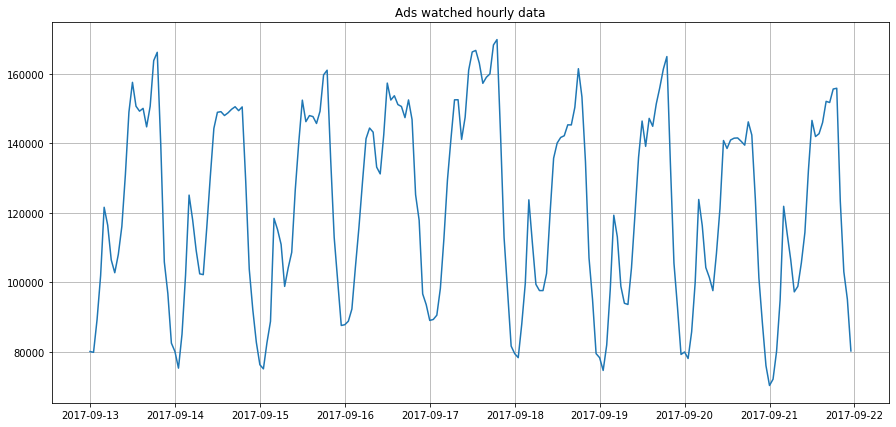

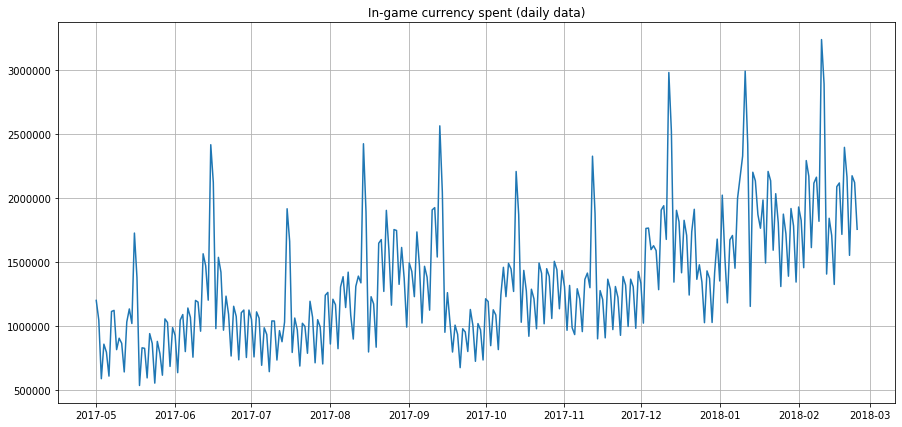

In [5]:
plt.figure(figsize = (15,7))
plt.plot(ads.Ads)
plt.title('Ads watched hourly data')
plt.grid(True)
plt.show()

plt.figure(figsize = (15,7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('In-game currency spent (daily data)')
plt.grid(True)
plt.show()

In [6]:
moving_average(ads, 24) # prediction for the last observed day (past 24 hours)

116805.0

Unfortunately we cannot use Moving Average, it has another use case- smoothing of the original time series to indicate trends. Pandas has an implementation available.<br>
`DataFrame.rolling(window).mean()`. The wider the window - the smoother wil be the trend. In the case of the very noisy data, which can be very often encountered in finance, this procedure can help to detect common patterns.

In [7]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    '''
        series - dataframe with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies
    
    '''
    
    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(15,5))
    plt.title("Moving Average \n window size ={}".format(window))
    plt.plot(rolling_mean, "g", label = "Rolling Mean Trend")
    
    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns = series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, 'ro', markersize = 10)
            print(series[anomalies.notna().values])
    plt.plot(series[window:], label="Actual Values")
    plt.legend(loc="upper left")
    plt.grid(True)


Why 1.96?
<br>
Hi! The scale actually comes from the underlying assumption of the normality (which, in all honesty, should be tested properly). If we believe our observations are normally distributed, then we say that 95% of our data should lie within 1.96 standard deviations from the mean. Naturally, this number may vary depending on the number of observations you want to cover. Say, you consider an observation to be an outlier if it lies further from the mean by 3 standard deviations, i.e. you cover 99.7% of data with the confidence interval. You may find more info here — https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule

<br>

For 95% the Z value is 1.960

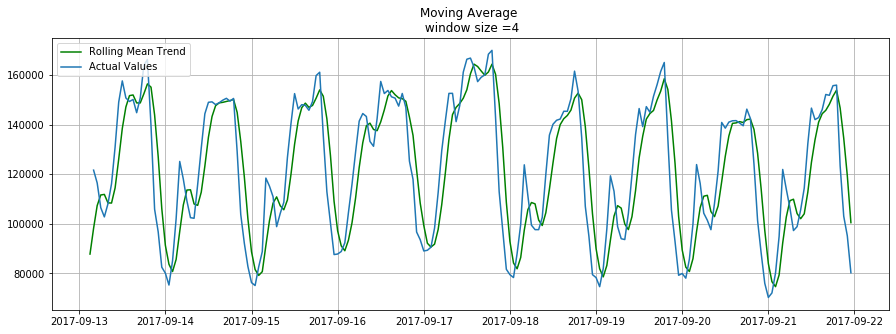

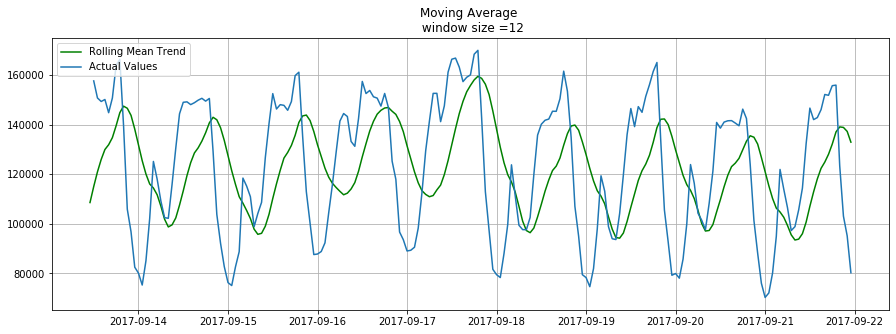

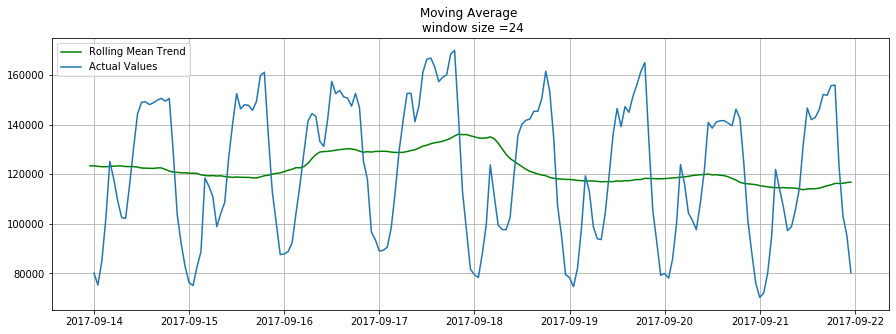

In [8]:
# smoothing by last 4 hours
plotMovingAverage(ads,4)
# smoothing by last 12 hours
plotMovingAverage(ads,12)
# smoothing by 24 hours- we get daily trend
plotMovingAverage(ads,24)

As you can see, applying daily smoothing on hour dat allowed us to clearly see the dynamics of ads watched. During the weekneds the values are higher. 
<br><br>
We can also plot confidence intervals for our smoothed values

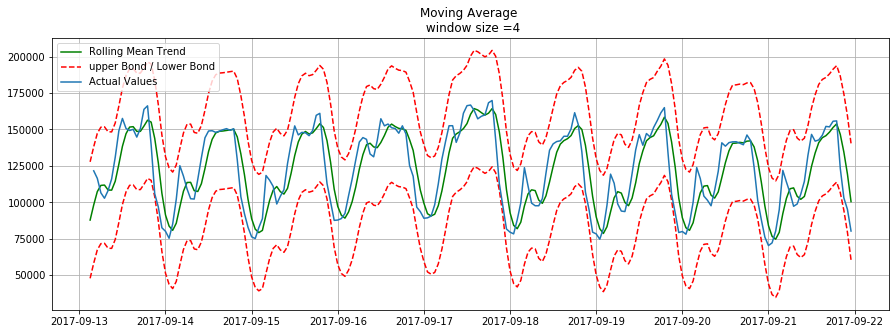

In [9]:
plotMovingAverage(ads, 4, plot_intervals = True)

                         Ads
Time                        
2017-09-21 04:00:00  24382.0


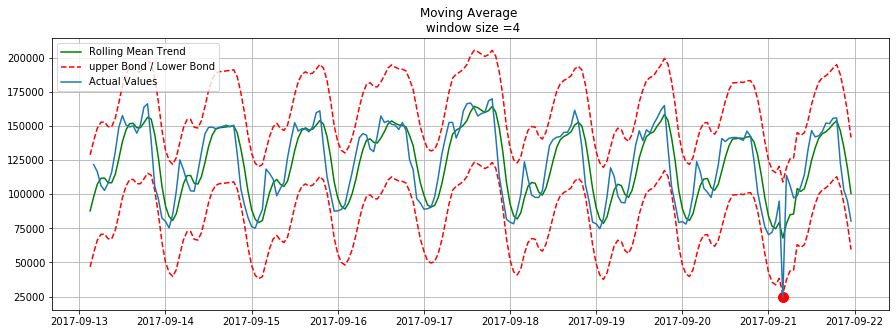

In [10]:
# create a abnormal in the dataframe
ads_anomaly = ads.copy()
ads_anomaly.iloc[-20] = ads_anomaly.iloc[-20] * 0.2 # say we have 80% drop of ads

# Lets see if we catch anomaly

plotMovingAverage(ads_anomaly, 4, plot_intervals=True, plot_anomalies=True)

What about the second series (with weekly smoothing)

            GEMS_GEMS_SPENT
Time                       
2017-06-15          2418723
2017-08-14          2426361
2017-09-13          2566462
2017-11-12          2328862
2017-12-12          2984329
2018-01-11          2995029
2018-01-13          1152460
2018-02-10          3242154


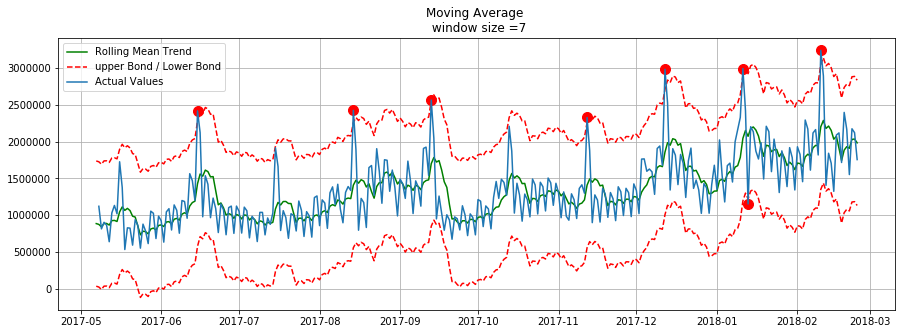

In [11]:
plotMovingAverage(currency, 7, plot_intervals=True, plot_anomalies = True)

**Here is the downside of the simple approach**, it did not catch monthly seasonality in our data and marked almost all 30 days peaks as an anomaly. We do not want to have that many false alarms. Need to consider more complex model

**Weighted average** is a simple modification of the moving average, inside of which observations have different weights summing up to one, usually more recent observations have greater weight.

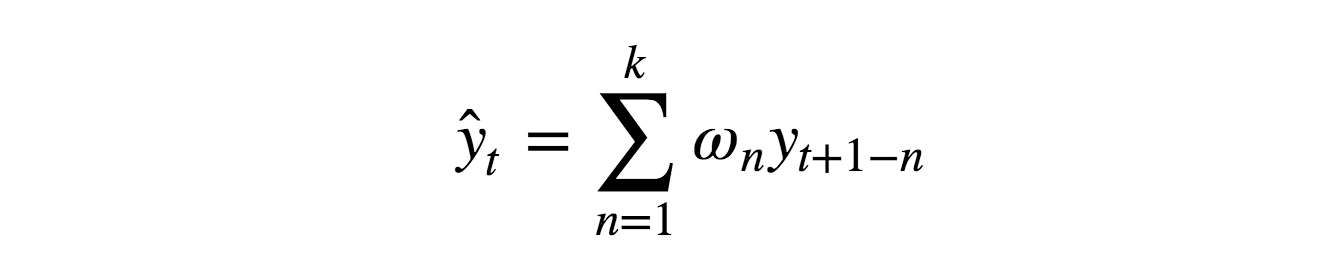

In [12]:
def weighted_average(series, weights):
    """
        Calculate weighter average on series
        weight: List of weight ratio
    """
    result = 0.0
    weights.reverse()                  # reverses the list,inplace=True 
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)
  
weighted_average(ads, [0.6, 0.3, 0.1])

98423.0

#### Exponential Smoothing
Let's take a look at what happens if instead of weighting the last n values of the time series we start weighting all avilable observations while exponentially decreasing weights as we move further back in historical data. The formula of simple exponential smoothing will help.
<br>
alpha is a smoothing factor, defines how quickly we will "forget" the last available true observation. 

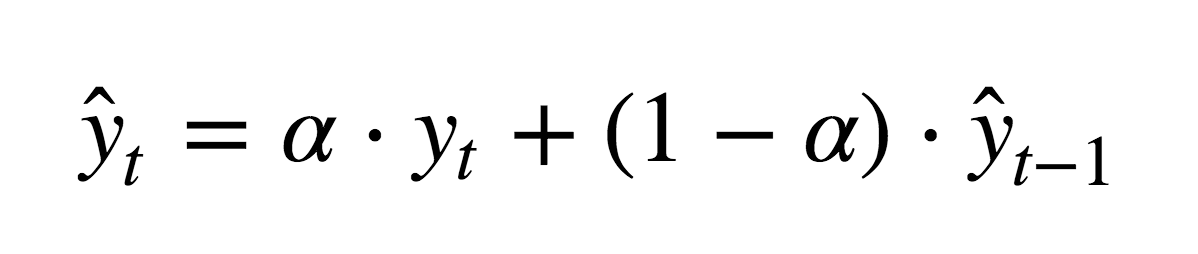

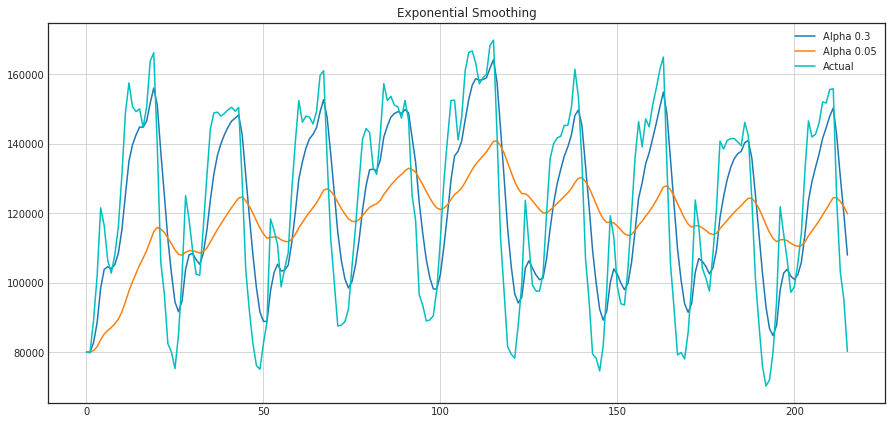

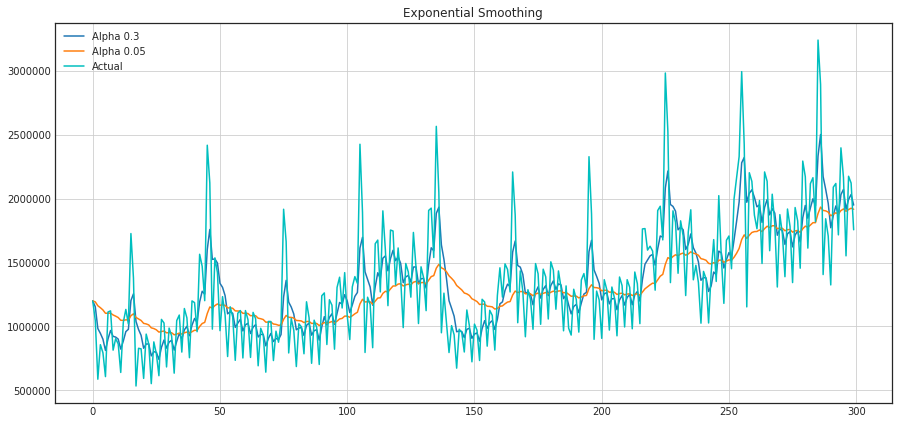

In [13]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series.tolist()[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series.tolist()[n] + (1 - alpha) * result[n-1])
    return result
    
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);
        
plotExponentialSmoothing(ads.Ads, [0.3, 0.05])
plotExponentialSmoothing(currency.GEMS_GEMS_SPENT, [0.3, 0.05])

#### Double Exponential Smoothing
A single future point prediction is not enough, so let's extend exponential smoothing so we can predict two future points.
<br>
Series decomposition should help us- obtain two components: intercept (also level) l and trend (also slope) b. We learn to predict intercept (or expected series value) using previous methods. We apply the same exponential smoothing to the trend, believing naively

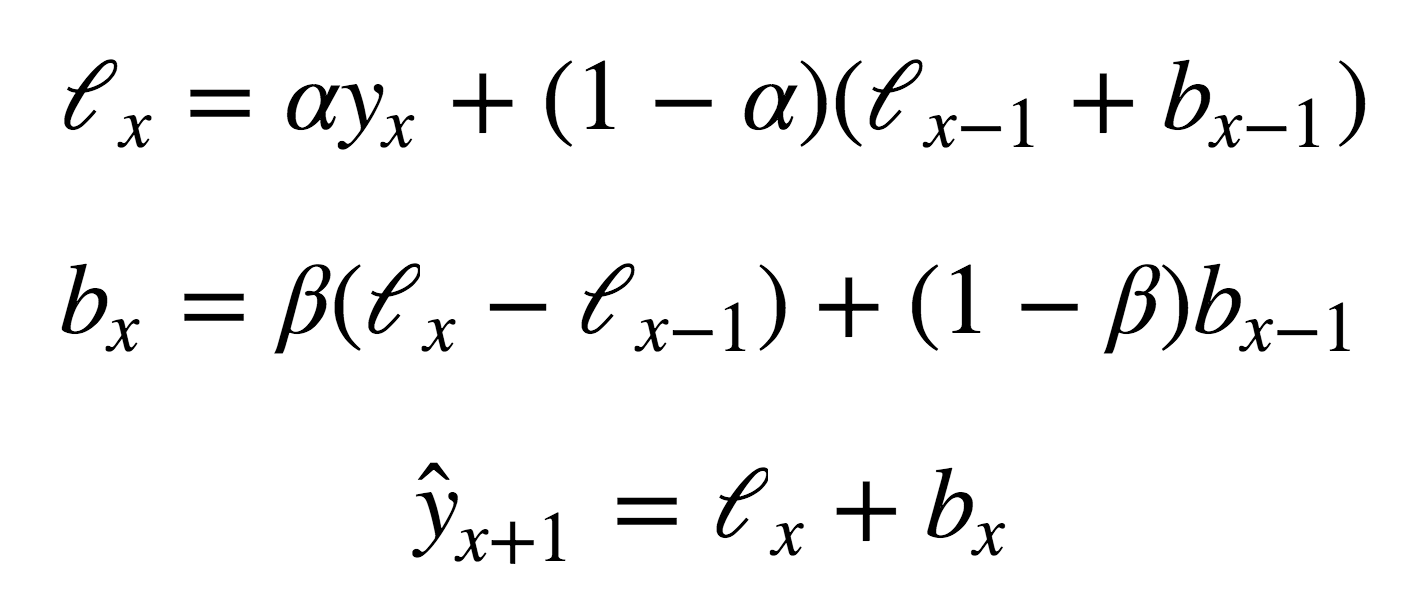

As a result we get a set of functions. The first one describes intercept, as before it depends on the current value of the series, and the second term is now split into previous values of the level and of the trend. The second function describes trend — it depends on the level changes at the current step and on the previous value of the trend. In this case β coefficient is a weight in the exponential smoothing. The final prediction is the sum of the model values of the intercept and trend.

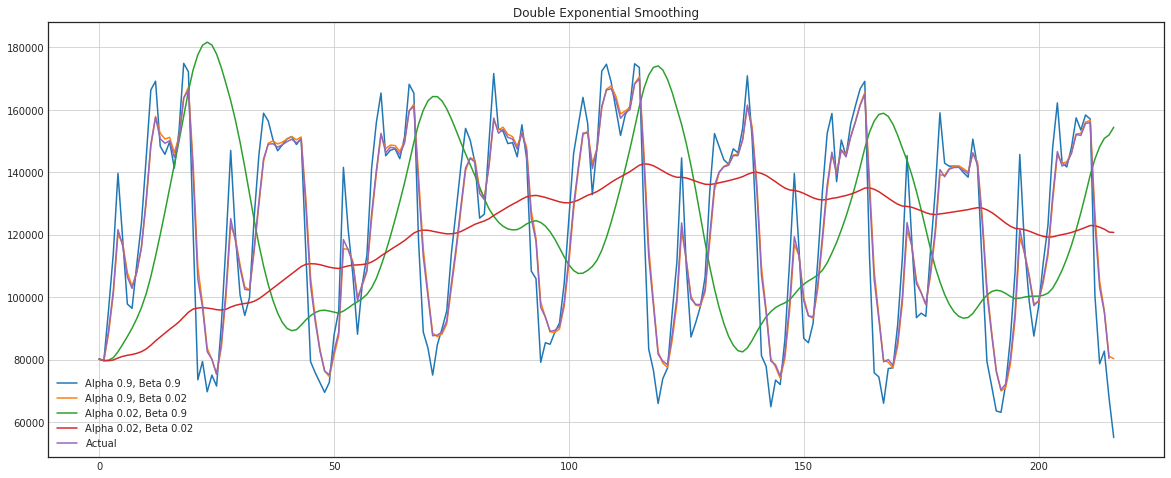

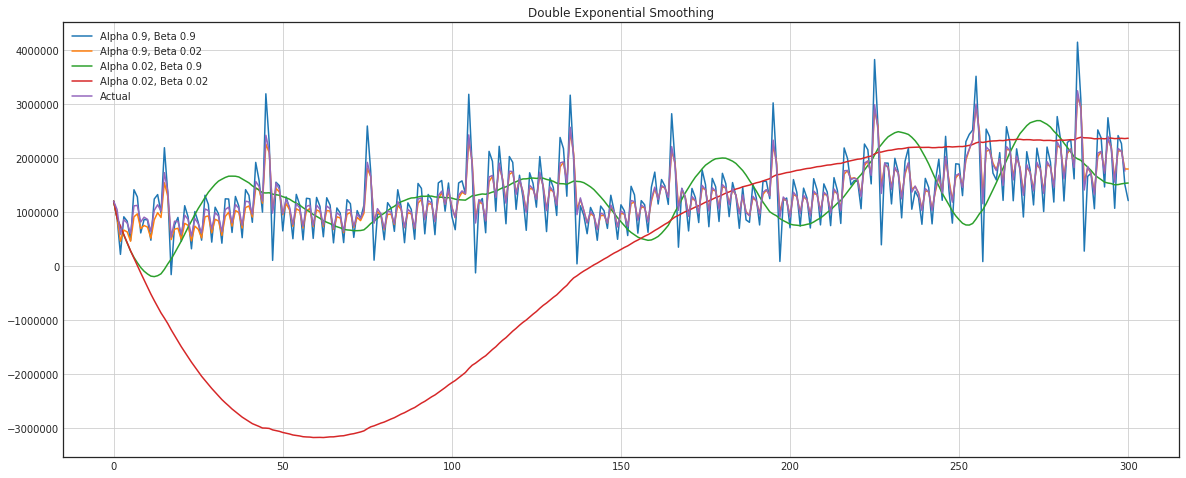

In [14]:
def double_exponential_smoothing(series, alpha, beta):
    '''
        series - dataset with timeseries
        alpha - float [0.0 , 1.0], soothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    '''
    
    # first value is same as series
    result = [series.tolist()[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series.tolist()[0], series.tolist()[1] - series.tolist()[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series.tolist()[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    '''
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    '''
    
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(20,8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label = 'Alpha {}, Beta {}'.format(alpha,beta))
        plt.plot(series.values, label = 'Actual')
        plt.legend(loc='best')
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)
        
plotDoubleExponentialSmoothing(ads.Ads, alphas = [0.9, 0.02], betas=[0.9,0.02])
plotDoubleExponentialSmoothing(currency.GEMS_GEMS_SPENT, alphas = [0.9, 0.02], betas=[0.9,0.02])

Alpha and Beta, bigger the values, the more weight the latest observations will have and the less smoothed the model series will be.

#### Triple Exponential Smoothing a.k.a Holt-Winters
The idea of this method is that we add another, third component **seasonality**. This means we shouldn't use the method if our time series do not have seasonality, which is not the case in our example. Seasonal components in the model will explain repeated variation around intercept and trend, and it will be described by the length of the season, in other words by the period after which variations repeat. For each observation in the season there's seperate component, for example, if the length of the season is 7 (weekly seasonality), we will have 7 seasonal components, one for each day of the week.

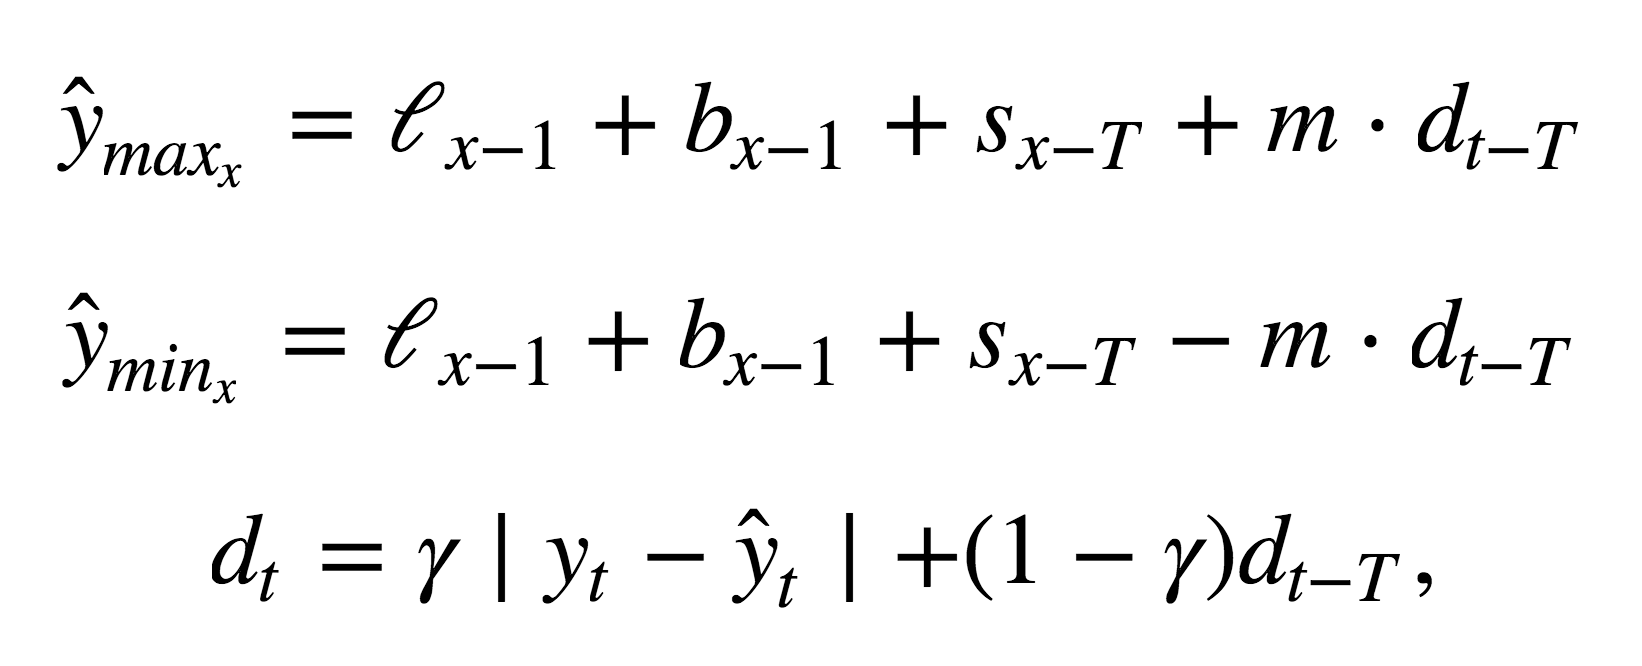

Intercept now depends on the current value of the series minus corresponding seasonal component, trend stays unchanged, and the seasonal component depends on the current value of the series minus intercept and on the previous value of the component. Please take into account that the component is smoothed through all the available seasons, for example, if we have a Monday component then it will only be averaged with other Mondays. You can read more on how averaging works and how initial approximation of the trend and seasonal components is done here. Now that we have seasonal component we can predict not one and not even two but arbitrary mm future steps which is very encouraging.
Below is the code for a triple exponential smoothing model, also known by the last names of its creators — Charles Holt and his student Peter Winters. Additionally Brutlag method was included into the model to build confidence intervals:

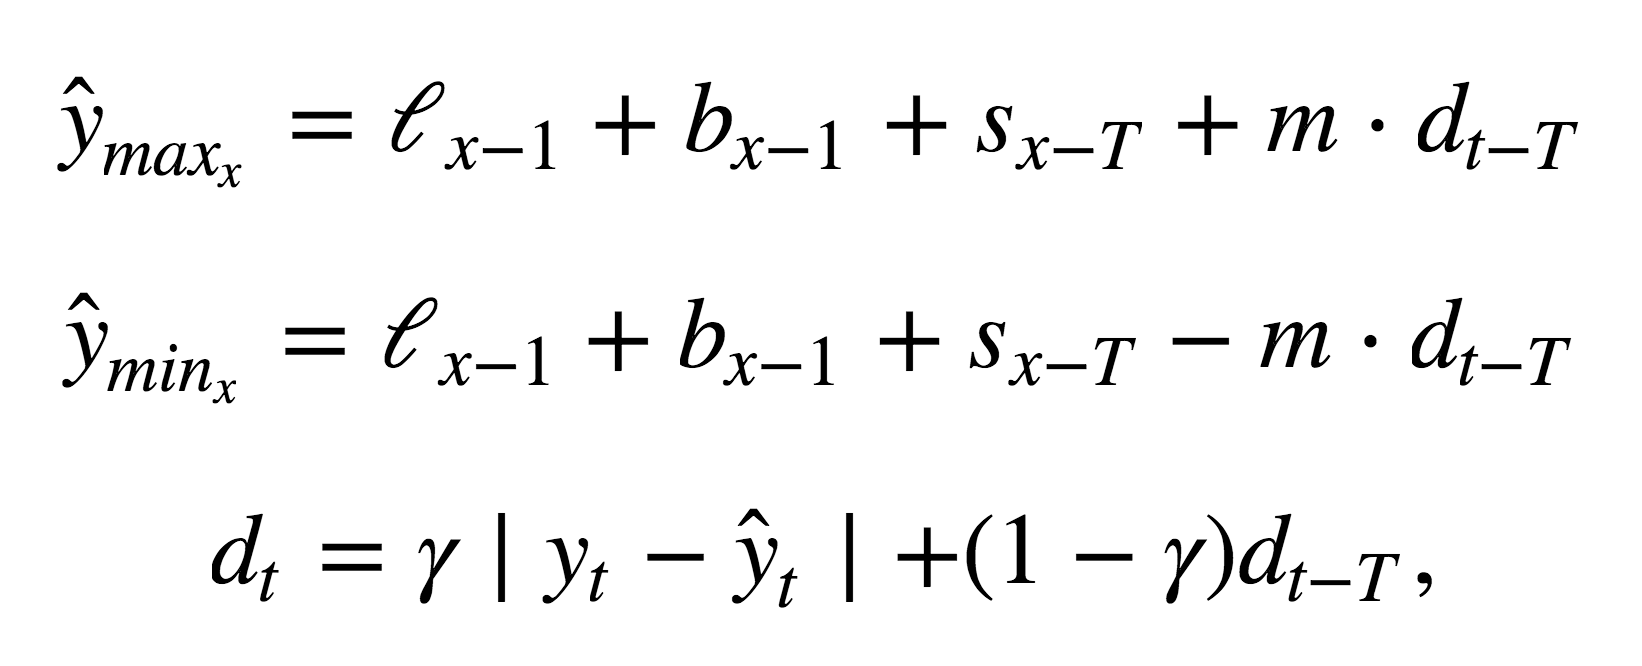

where T is the length of the season, d is the predicted deviation, and the other parameters were taken from the triple exponential smoothing. You can read more about the method and its applicability to anomalies detection in time series here.

In [15]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

## Time series cross validation
Before we start building model let’s talk first about how to estimate model parameters automatically. <br><br>
There’s nothing unusual here, as always we have to choose a loss function suitable for the task, that will tell us how close the model approximates data. Then using cross-validation we will evaluate our chosen loss function for given model parameters, calculate gradient, adjust model parameters and so forth, bravely descending to the global minimum of error. <br><br>
The question is how to do cross-validation on time series, because, you know, **time series do have time structure and one just can’t randomly mix values in a fold without preserving this structure, otherwise all time dependencies between observations will be lost.** That’s why we will have to use a bit more tricky approach to optimization of the model parameters, I don’t know if there’s an official name to it but on CrossValidated, where one can find all the answers but the Answer to the Ultimate Question of Life, the Universe, and Everything, “cross-validation on a rolling basis” was proposed as a name.<br><br>

The idea is rather simple — we train our model on a small segment of the time series, from the beginning until some t, make predictions for the next t+n steps and calculate an error. Then we expand our training sample until t+n value and make predictions from t+n until t+2∗n, and we continue moving our test segment of the time series until we hit the last available observation. As a result we have as many folds as many n will fit between the initial training sample and the last observation.

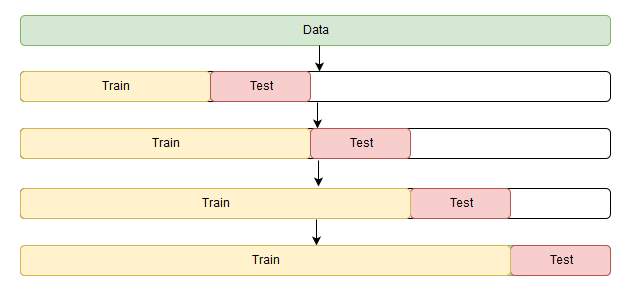

Now, knowing how to set cross-validation, we will find optimal parameters for the Holt-Winters model, recall that we have daily seasonality in ads, hence the `slen=24` parameter


In [16]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In the Holt-Winters model, as well as in the other models of exponential smoothing, there’s a constraint on how big smoothing parameters could be, each of them is in the range from 0 to 1, therefore to minimize loss function we have to choose an algorithm that supports constraints on model parameters, in our case — Truncated Newton conjugate gradient.

In [17]:
%%time
data = ads.Ads[:-20] # leave some data for testing

# initializing model parameters alpha, beta, and gamma
x = [0,0,0]

# minimizing the loss function
opt = minimize(timeseriesCVscore, x0=x,
              args=(data, mean_squared_log_error),
              method = "TNC", bounds = ((0,1),(0,1),(0,1))
              )
# take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting the next 50 hours
model = HoltWinters(data, slen = 24,
                   alpha = alpha_final,
                   beta= beta_final,
                   gamma = gamma_final,
                   n_preds = 50,
                   scaling_factor = 3)

model.triple_exponential_smoothing()

0.11652680227350454 0.002677697431105852 0.05820973606789237
Wall time: 3.43 s


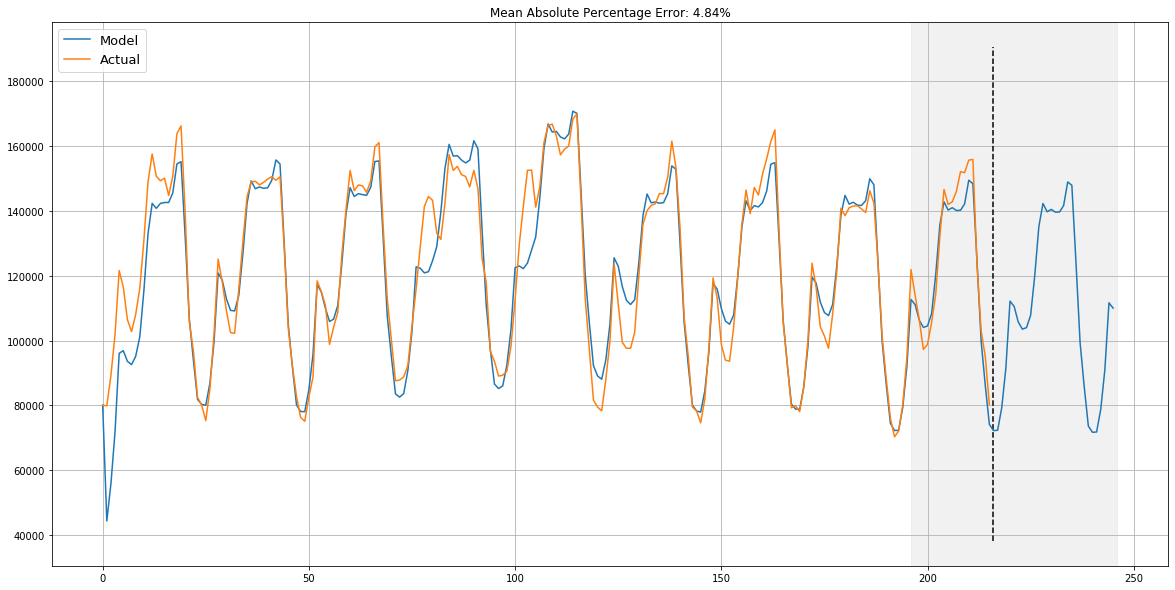

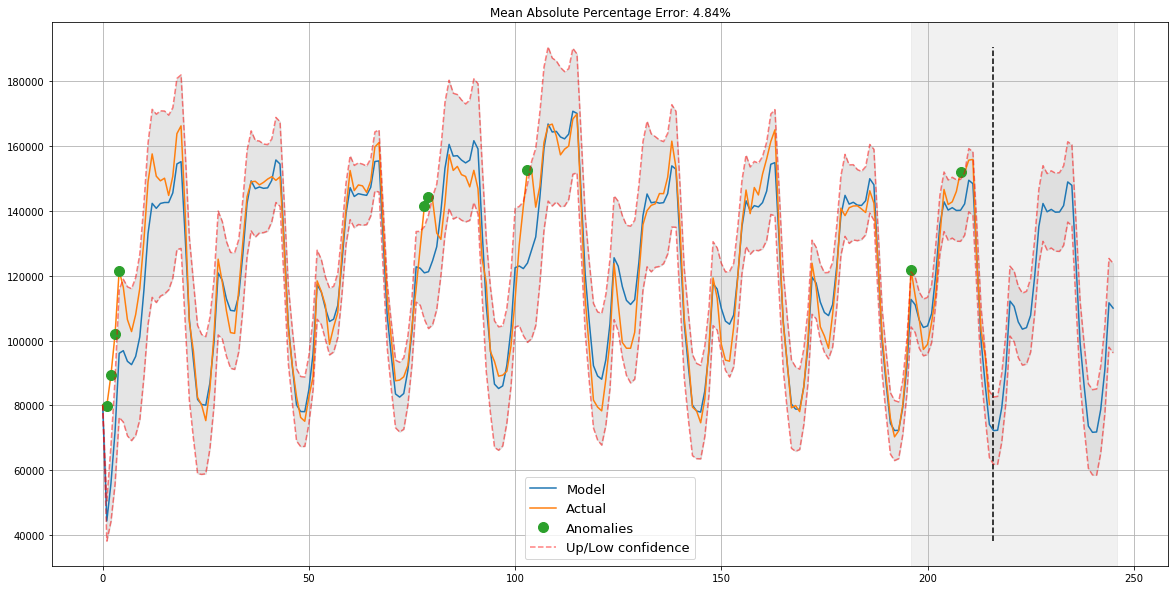

In [18]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);
    
plotHoltWinters(ads.Ads)
plotHoltWinters(ads.Ads, plot_intervals=True, plot_anomalies=True)

Judging by the chart, our model was able to successfully approximate the initial time series, catching daily seasonality, overall downwards trend and even some anomalies.

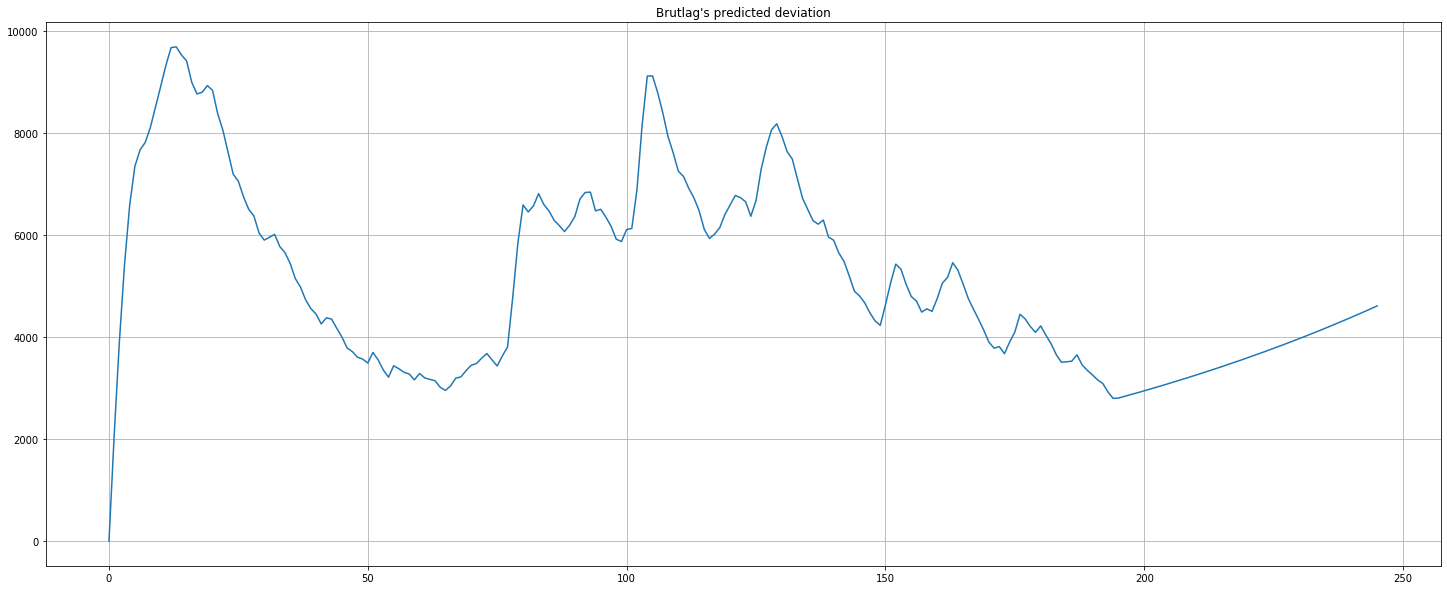

In [19]:
plt.figure(figsize=(25, 10))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

 If you take a look at the modeled deviation, you can clearly see that the model reacts quite sharply to the changes in the structure of the series but then quickly returns deviation to the normal values, "forgetting" the past. This feature of the model allows us to quickly build anomaly detection systems even for quite noisy series without spending too much time and money on preparing data and trainng the model.

We’ll apply the same algorithm for the second series which, as we know, has trend and 30-day seasonality

In [20]:
%%time
data = currency.GEMS_GEMS_SPENT[:-50] 
slen = 30 # 30-day seasonality

x = [0, 0, 0] 

opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_absolute_percentage_error, slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 100, scaling_factor = 3)
model.triple_exponential_smoothing()

0.012841445048055122 0.04883371471892228 0.00943678056045777
Wall time: 6.73 s


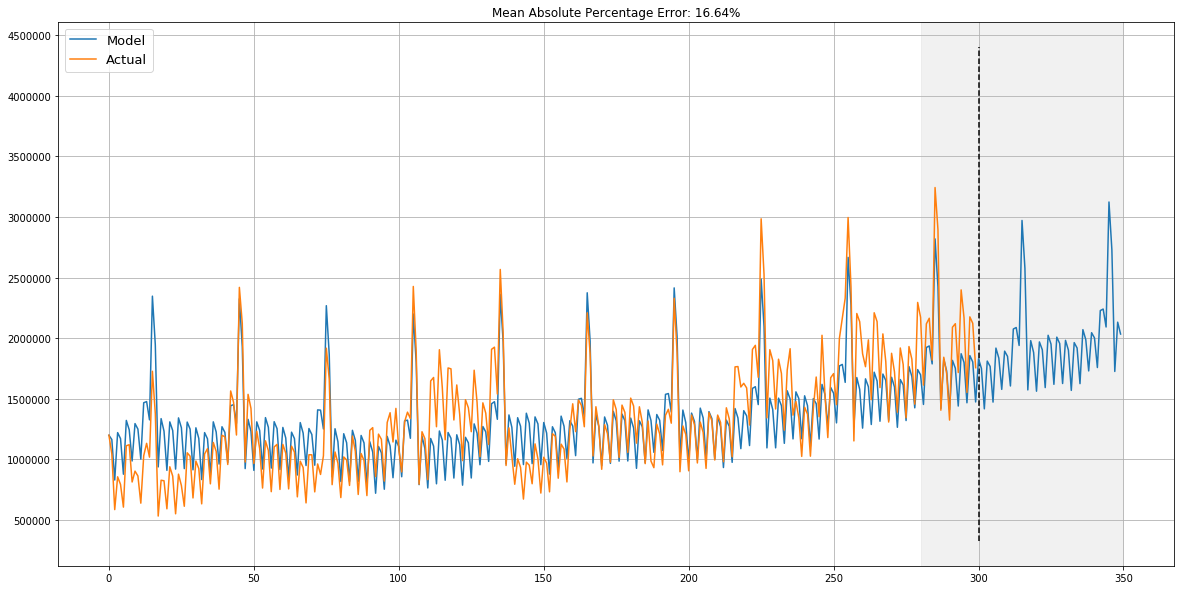

In [21]:
plotHoltWinters(currency.GEMS_GEMS_SPENT)

Looks quite adequate, model has caught both upwards trend and seasonal spikes and overall fits our values nicely


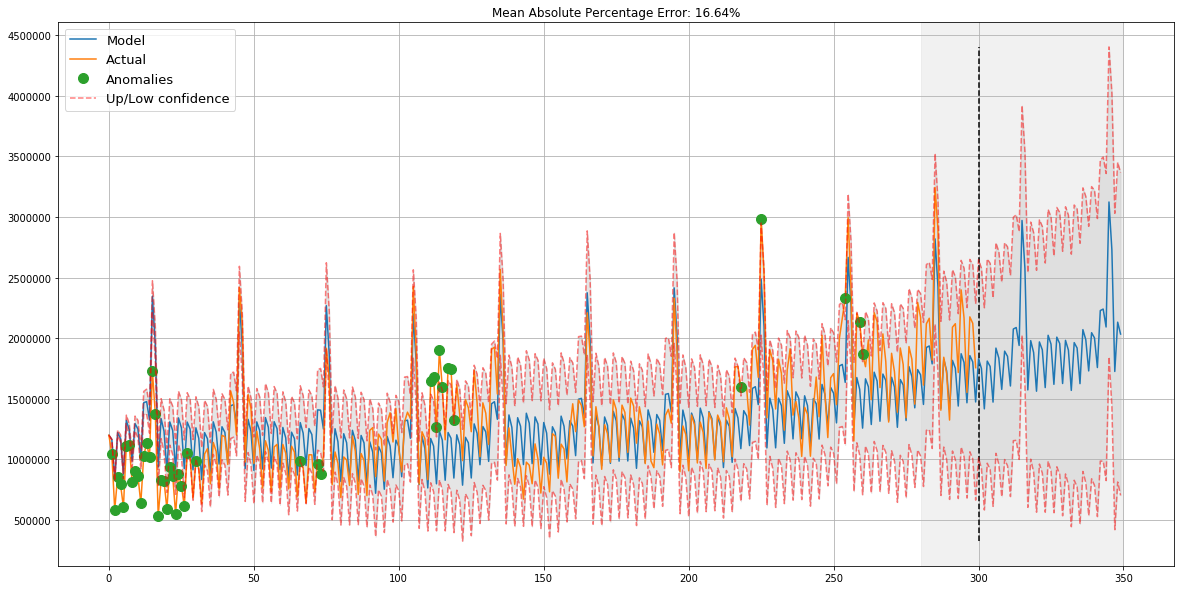

In [22]:
plotHoltWinters(currency.GEMS_GEMS_SPENT, plot_intervals=True, plot_anomalies=True)

Caught some anomalies as well


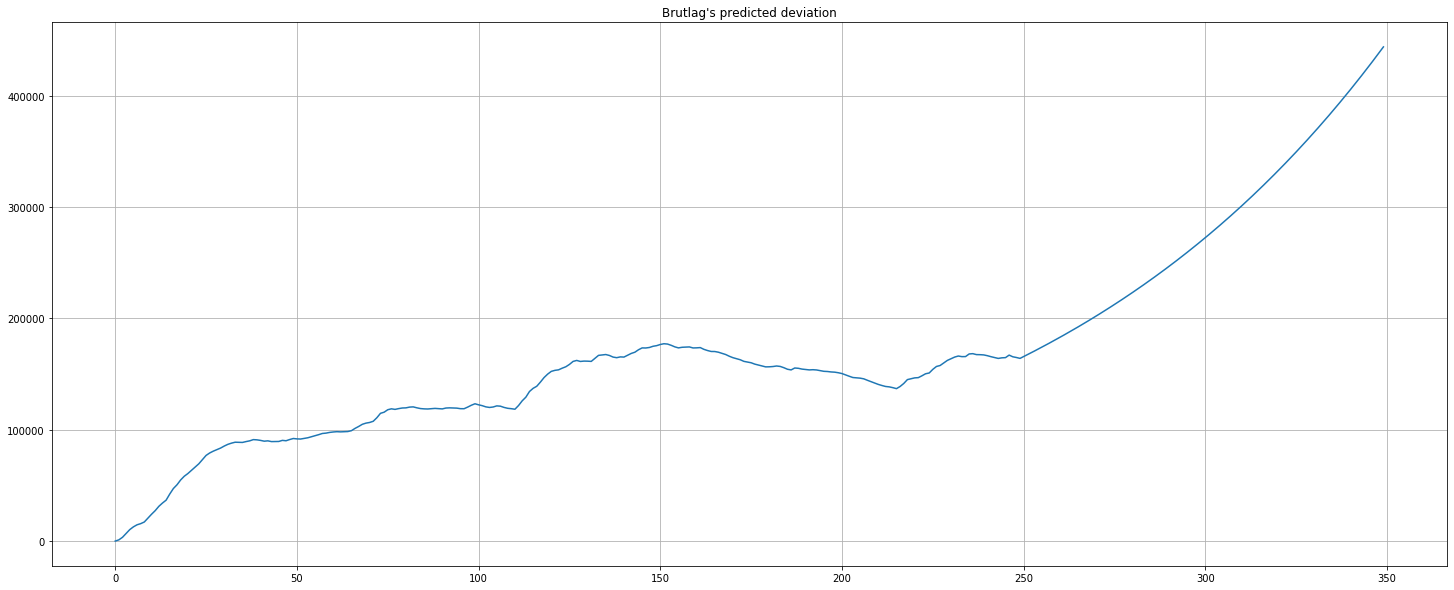

In [23]:
plt.figure(figsize=(25, 10))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

Deviations increases as forecast period moves further

## Econometric Approach

### Stationarity

Before we start modeling we should mention such an important property of time series as ***stationarity***

<br>
If the process is stationary that means it doesn't change its statistical properties over time, namely mean and variance do not change over time (constancy of variance is also called **homoscedasticity**), also covariance function does not depend on the time (should only depend on the distance between observations). You can see this visually on the picture.

- the red graph below is not stationary because the mean increases over time
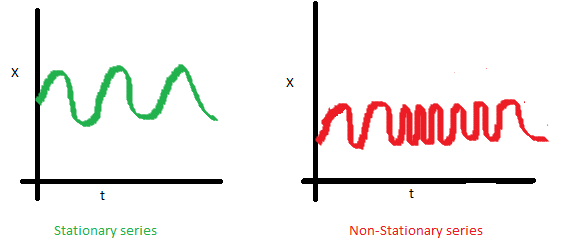
- we were unlucky with the variacne, see the varying spread of values over time.
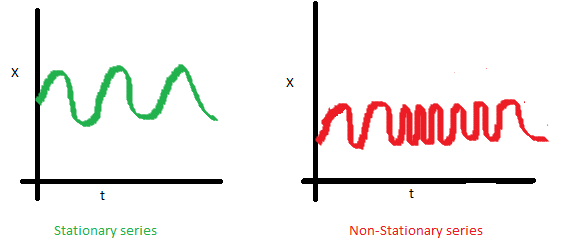
- Finally, the covariance of the i th term and the (i + m) th term should not be a function of time. In the following graph, you will notice the spread becomes closer as the time increases. Hence, the covariance is not constant with time for the right chart.
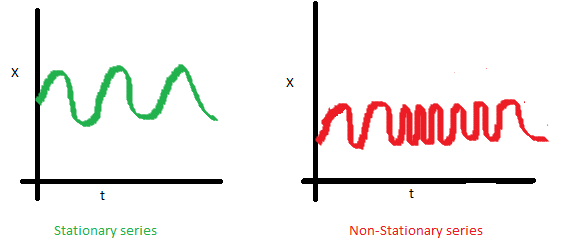


So why stationarity is so important? **Because it is easy to make predictions on the statinoary series as we assume that the future statistical properties will not be different from the currently observed.** Most of the time series models in one way or the other model and predict those properties (mean or variance, for example), that's why predictions would be wrong if the original series were not stationary. Unfortunately most of the time series we see outside of textbooks are non-stationary but we can (and should) change this.

So, to fight non-stationarity we have to know our enemy so to say. Let’s see **how to detect it**. To do that we will now take a look at the white noise and random walks and we will learn how to get from one to another for free, without registration and SMS.

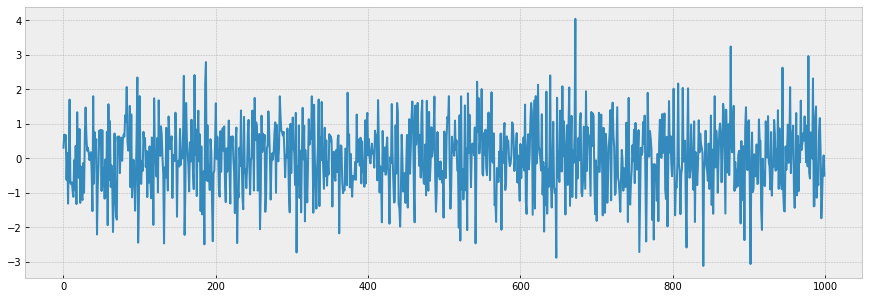

In [24]:
# White noise chart:

white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):  
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

So the process generated by standard normal distribution is stationary and oscillates around 0 with with deviation of 1. Now based on this process we will generate a new one where each next value will depend on the previous one: x(t)=ρ*x(t−1)+e(t)

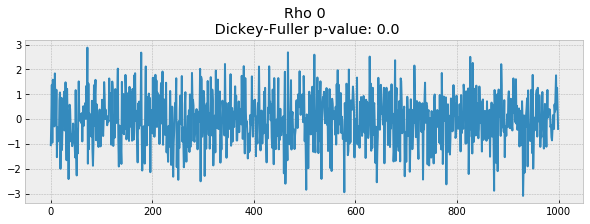

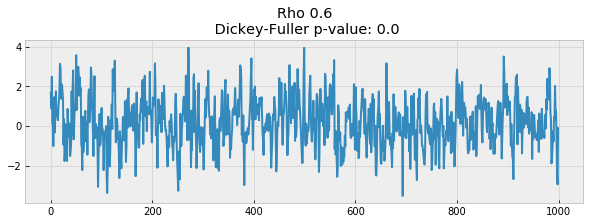

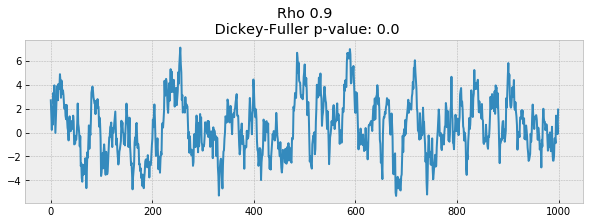

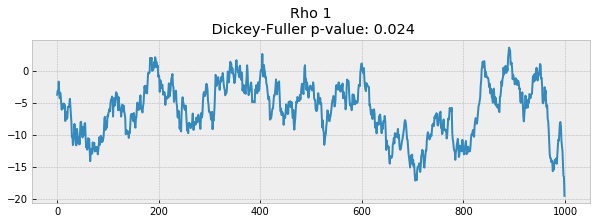

In [25]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))
        
for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

On the first chart you can see the same stationary white noise you’ve seen before. On the second one the value of ρρ increased to 0.6, as a result wider cycles appeared on the chart but overall it is still stationary. The third chart deviates even more from the 0 mean but still oscillates around it. Finally, the value of ρ equal to 1 gives us a random walk process — non-stationary time series.

This happens because after reaching the critical value the series x(t)=ρ*x(t−1)+e(t) does not return to its mean value. If we subtract x(t−1) from the left and the right side we will get x(t)−x(t−1)=(ρ−1)*x(t−1)+e(t), where the expression on the left is called the first difference. If ρ=1 then the first difference gives us stationary white noise e(t). This fact is the main idea of the Dickey-Fuller test for the stationarity of time series (presence of a unit root). If we can get stationary series from non-stationary using the first difference we call those series integrated of order 1. Null hypothesis of the test — time series is non-stationary, was rejected on the first three charts and was accepted on the last one. We’ve got to say that the first difference is not always enough to get stationary series as the process might be integrated of order d, d > 1 (and have multiple unit roots), in such cases the augmented Dickey-Fuller test is used that checks multiple lags at once.

<br>
We can fight non-stationarity using different approaches — various order differences, trend and seasonality removal, smoothing, also using transformations like Box-Cox or logarithmic.

## Getting rid of non-stationarity and building SARIMA

Now let’s build an ARIMA model by walking through all the circles of hell stages of making series stationary.

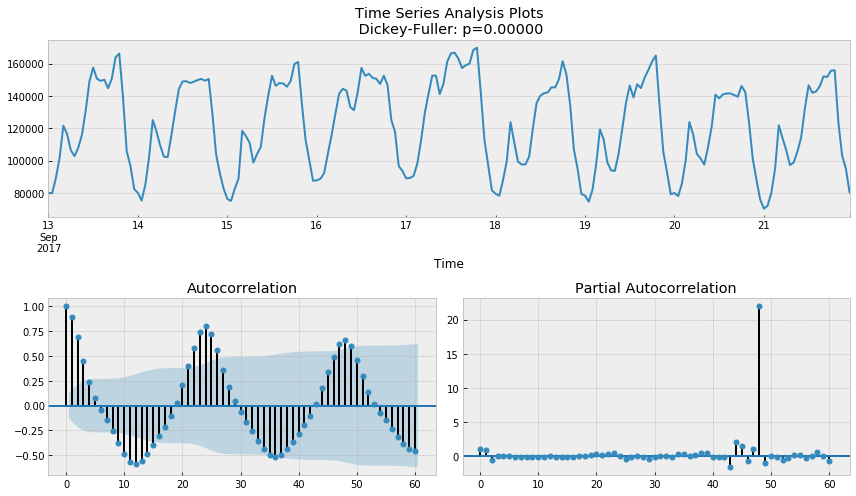

In [26]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(ads.Ads, lags=60)

Surprisingly, initial series are stationary, Dickey-Fuller test rejected null hypothesis that a unit root is present. Actually, it can be seen on the plot itself — we don’t have a visible trend, so mean is constant, variance is pretty much stable throughout the series.<br>
The only thing left is seasonality which we have to deal with before modelling. To do so let’s take “seasonal difference” which means a simple subtraction of series from itself with a lag that equals the seasonal period.

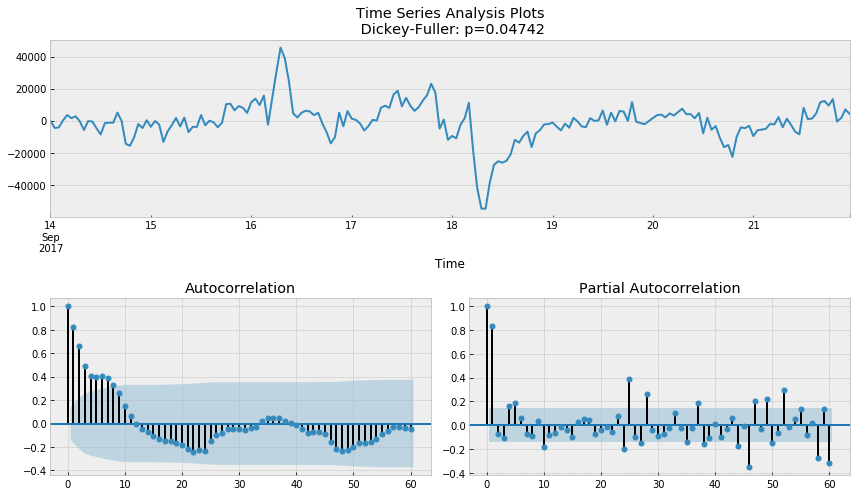

In [27]:
ads_diff = ads.Ads - ads.Ads.shift(24)
tsplot(ads_diff[24:], lags=60)

That’s better, visible seasonality is gone, however autocorrelation function still has too many significant lags. To remove them we’ll take first differences — subtraction of series from itself with lag 1

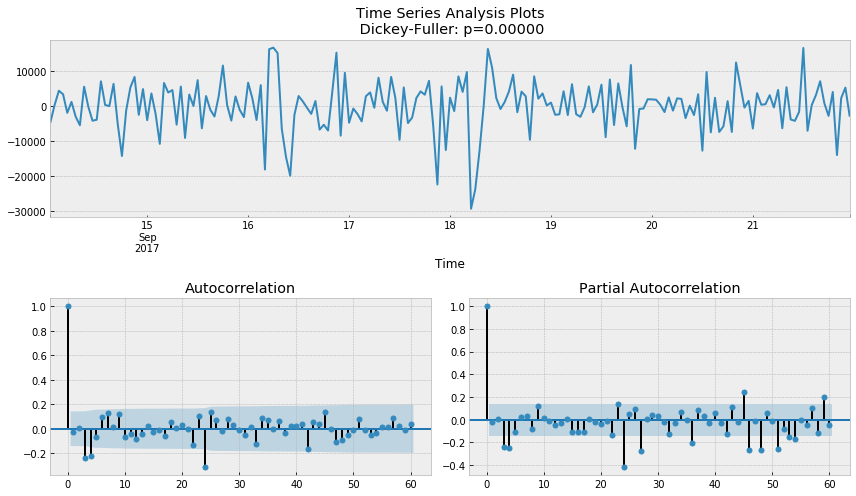

In [28]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=60)

Perfect! Our series now look like something undescribable, oscillating around zero, Dickey-Fuller indicates that it’s stationary and the number of significant peaks in ACF has dropped. We can finally start modelling!

Seasonal Autogregerssion Moving Average Model: <br>
AR (p): Autoregression model. assumption - current series values depend on its previous values with some lag. maximum lag in the model is referred as p. to determine the initial p, you need to plot PACF find the biggest significant lag, which most other lags are beocming not significant <br>
MA (q): Moving average model. assumption - current error depends on the previous with some lag, which is referred as q. Initial value can be found on ACF plot.
I (d): order of integeration. Number of nonseasonal differences needed for making the series stationary. 
S (s): Seasonality and equals the season period length of the series.


In [29]:
ps = range(2,5)
d = 1
qs = range(2,5)
Ps = range(0,3)
D = 1
Qs = range(0,2)
s = 24

parameters = product(ps,qs,Ps,Qs)
parameters_list = list(parameters)
len(parameters_list)

54

In [30]:
def optimizeSARIMA(parameter_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p,q,P,Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        # we need to try-except because on some combinations model fails to converge
        try:
            model = sm.tsa.statespace.SARIMAX(ads.Ads, order=(param[0],d,param[1]),
                                             seasonal_order=(param[2],D,param[3],s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saivng the best model
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
    
    result_table = pd.DataFrame(results)
    result_table.columns =['parameters','aic']
    # sorting in ascending order, in the lower AIC is - the better
    result_table = result_table.sort_values(by='aic',ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimizeSARIMA(parameters_list,d,D,s)

In [31]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(ads.Ads, order=(p,d,q),
                                      seasonal_order=(P,D,Q,s)).fit(disp=-1)

print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                Ads   No. Observations:                  216
Model:             SARIMAX(2, 1, 3)x(1, 1, 1, 24)   Log Likelihood               -1936.321
Date:                            Wed, 30 Oct 2019   AIC                           3888.642
Time:                                    11:18:56   BIC                           3914.660
Sample:                                09-13-2017   HQIC                          3899.181
                                     - 09-21-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7913      0.270      2.928      0.003       0.262       1.321
ar.L2         -0.5503      0.306   

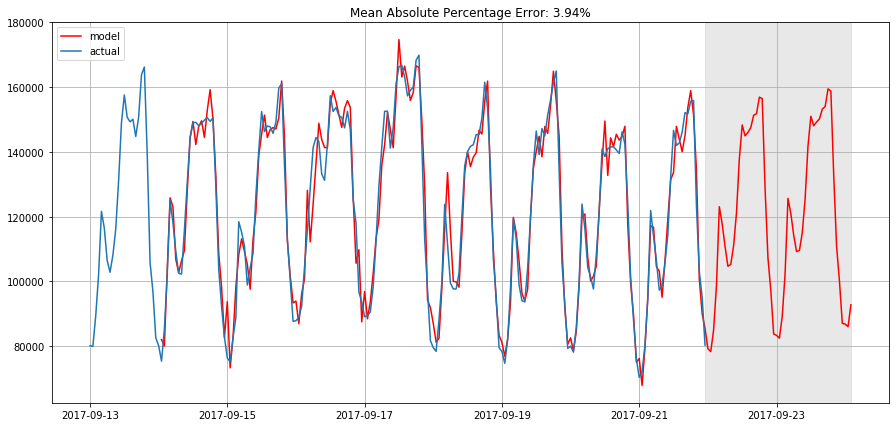

In [32]:
def plotSARIMA(series, model, n_steps):
    """
        plot model vs prediction values
        
        series - data set with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
    """
    
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    
    #making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    
    # calculate the error, again having shifted on s+d steps form the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(15,7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

plotSARIMA(ads, best_model, 50)

Feature Extraction
Alright, model needs features and all we have may be a few or 1-dimensional timeseries to work with. What features can we extract?

**Lags of time series,**

*Window Statistics:*
- max/min value of series in a window
- avg/median value in a window
- window variance
- etc.

*Date and time Features:*
- minutes of an hour, hour of a day, day of the week
- is this day a holiday (boolean)

## Lags of time series
shifting the series n steps back we get a feature column where the current value of timesries is aligned with its value at the time t-n. if we make a 1 lag shift and train a model on that feature, the model will be able to forecast 1 step ahead having observed current state of the series. Increasing the lag, say, up to 6 will allow the model to make predictions 6 steps ahead, however it will use data, observed 6 steps back. If something fundamentally changes the series during that unobserved period, the model will not catch the changes and will return forecast with big error. So during the initial lag selection one has to find a balance between the optimal prediction quality and the length of forecasting horizon.

In [33]:
data = pd.DataFrame(ads.Ads.copy()) # copy the ad values in a new DF
data.columns = ['y']                # change the column name to Y

# adding the lag of the target variable from 6 steps back up to 24
for i in range(6,25):
    data["lag_{}".format(i)] = data.y.shift(i)

In [34]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)


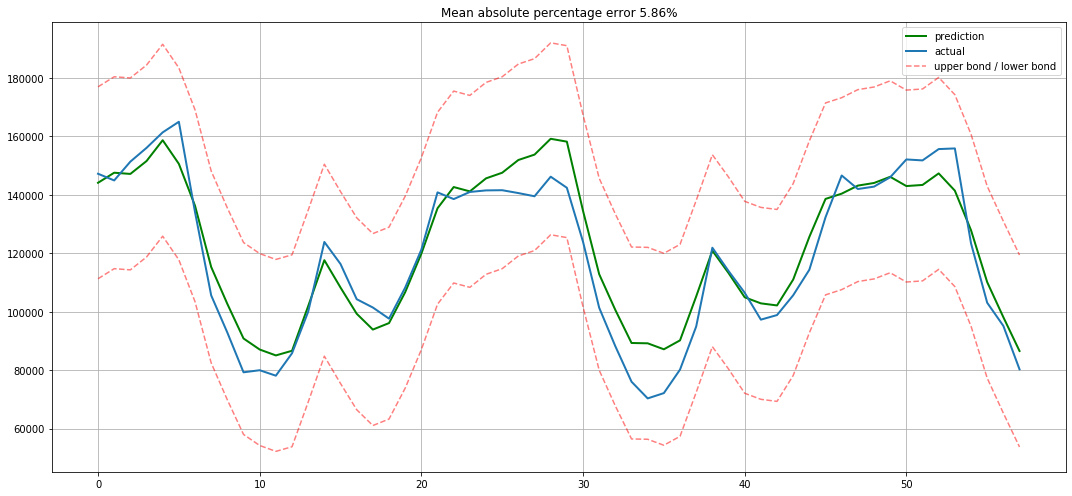

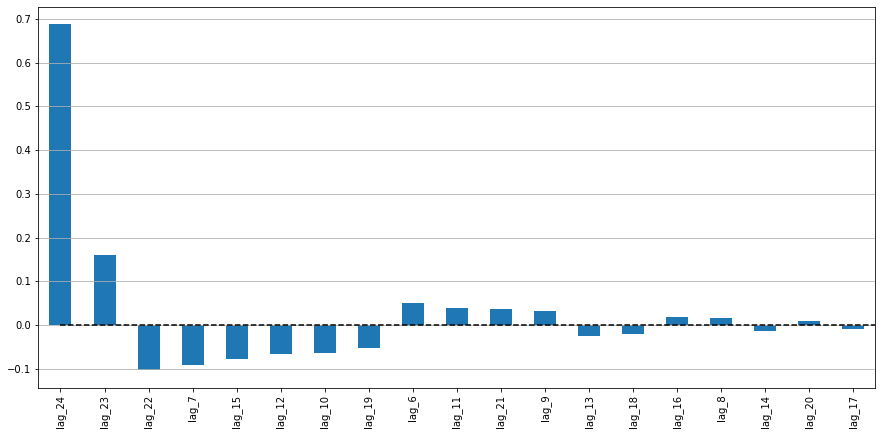

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
        test_size: percentage
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test


def plotModelResults(model, X_train, X_test, plot_intervals=False, plot_anomalies=False, scale=1.96):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv = tscv, 
                                    scoring="neg_mean_squared_error")
        #mae = cv.mean() * (-1)
        deviation = np.sqrt(cv.std())
        
        lower = prediction - (scale * deviation)
        upper = prediction + (scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)  # model.coef_
    coefs.columns = ["coef"]
    
    #by taking absolute values and sort. then drop
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');
    
    
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

plotModelResults(lr, X_train, X_test, plot_intervals=True)
plotCoefficients(lr)


Keep feature engineering: <br>

add day of the week and boolean for the weekend. To do so, need to transform current dataframe index into datetime format and extract hour and weekday out of it.

In [36]:
data['hour'] = data.index.hour
data['weekday'] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6]) * 1

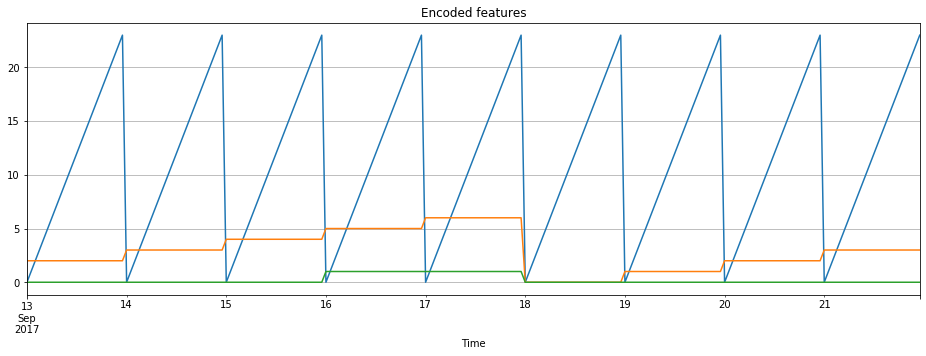

In [37]:
# Visualize the hour, weekday, weekend features
plt.figure(figsize=(16,5))
plt.title("Encoded features")
data.hour.plot()
data.weekday.plot()
data.is_weekend.plot()
plt.grid(True);

If we have different scale of variables - thousands for lags, tens for categorical. <br><br>
We need to transform them into same scale to continue exploring feature importance and later - regularization

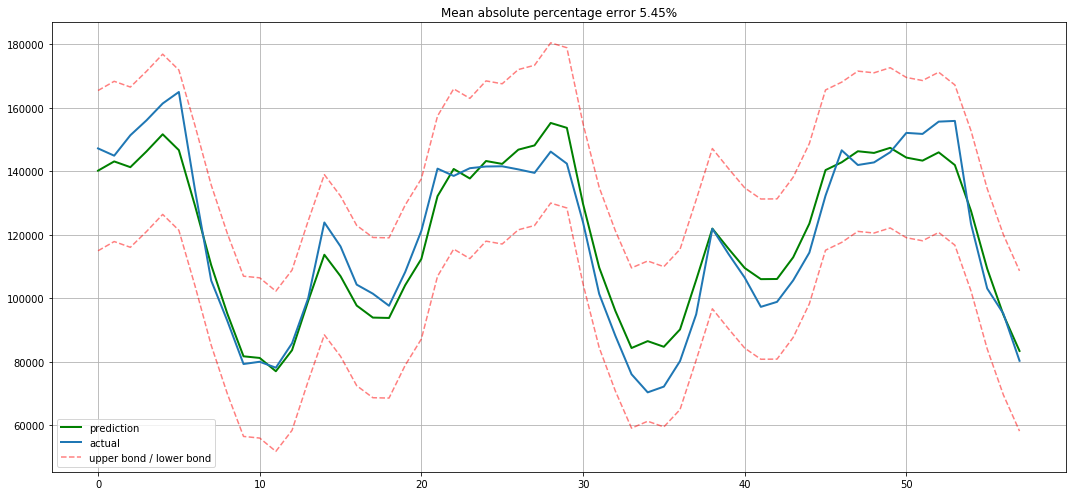

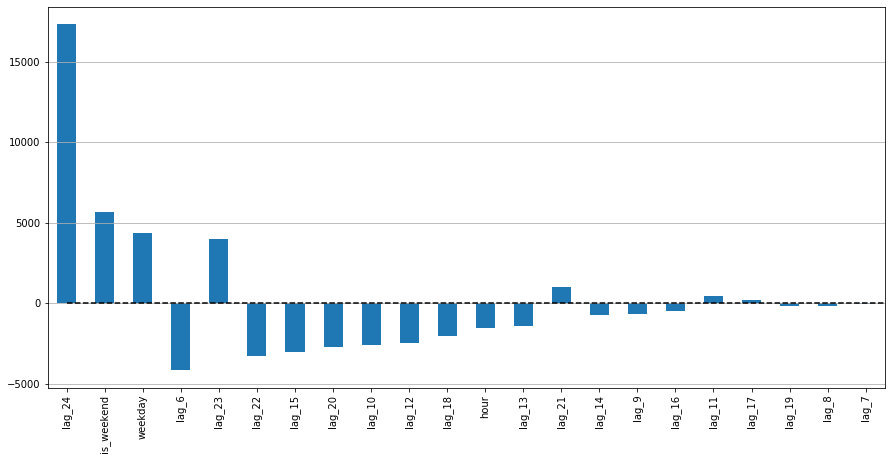

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
rscaler = RobustScaler()
mmscaler = MinMaxScaler()

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

Test error goes down a little bit and judging by the coefficients plot we can say that weekday and is_weekend are rather useful features

# Target Encoding
Another variant of encoding categorical variables - by mean value. If it's undesirable to explode dataset by using tons of dummy variables that can lead to the loss of information about the distance, and if they can't be used as areal values because of the conflicts like 0 hours < 23 hours. <br>
Then it is possible to encode a variable with a little bit more interpretable value. Natural idea is to encode with the mean value of the target variable. In our example, everyday of the week and every hour of the day can be encoded by the corresponding average number of ads watched during that day of hour. It is very important to make sure that the mean value is calculated over train set only (or over current cross-validation fold only), so that the model is not aware of the future

In [39]:
def code_mean(data, cat_feature, real_feature):
    '''
        Returns a dictionary where key are unique categories of the cat_feature,
        and values are means over real_feature
    '''
    
    return dict(data.groupby(cat_feature)[real_feature].mean())

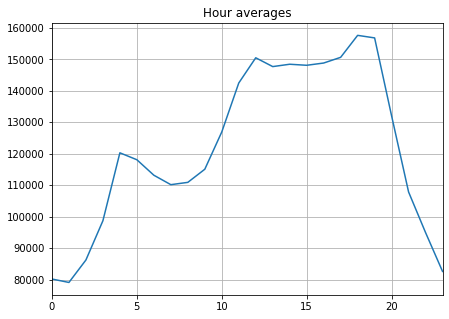

In [40]:
average_hour = code_mean(data, 'hour', 'y')
plt.figure(figsize=(7,5))
plt.title("Hour averages")
pd.DataFrame.from_dict(average_hour, orient='index')[0].plot()
plt.grid(True)

Put all the transformations together in a single function

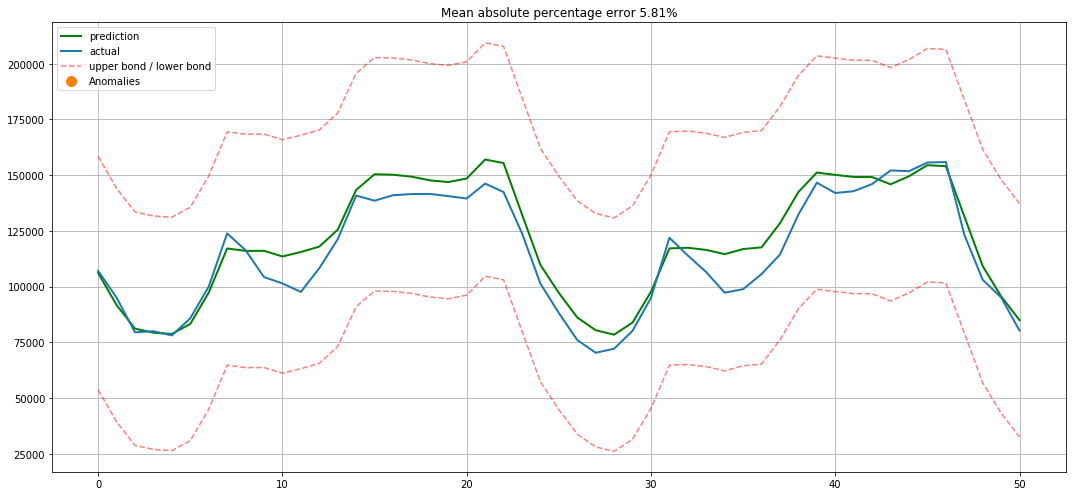

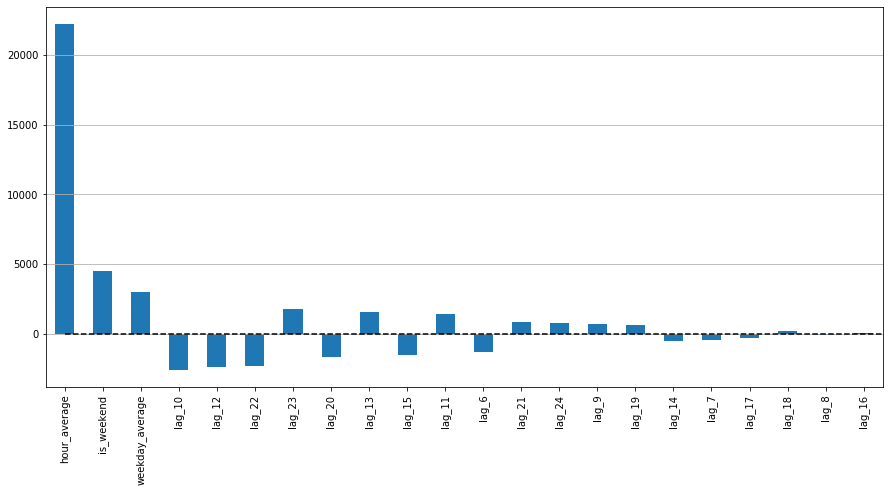

In [41]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries
        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today
        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today
        test_size: float
            size of the test dataset after train/test split as percentage of dataset
        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features
#     data.index = data.index.to_datetime()
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(
            code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["hour_average"] = list(map(
            code_mean(data[:test_index], 'hour', "y").get, data.hour))

        # frop encoded variables 
        data.drop(["hour", "weekday"], axis=1, inplace=True)
    
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test =\
    timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test
  
  

X_train, X_test, y_train, y_test =\
prepareData(ads.Ads, lag_start=6, lag_end=25, test_size=0.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

The error is higher! which means **overfitting**.
<br> Hour_average variable was so great on the train dataset that the model decided to concentrate all its forces on it. As a result, the quality of prediction dropped. THis problem can be approached in a variety of ways, for example, we can calculate target encoding not for the whole train set, but for some window instead, that way encodings from the last observed window will probably describe current series state better. Or we can just drop it manually, since we are sure here it makes things worse.

In [42]:
X_train, X_test, y_train, y_test = \
prepareData(ads.Ads, lag_start=6, lag_end=25, test_size=0.3, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled =scaler.fit_transform(X_test)

# Regularization and feature selection
as we already know, not all features are equally healthy, some may lead to overfitting and create noise, which should be removed. Besides manual inspecting we can apply regularization. Two most popular regression models with regularization are Ridge and Lasso. They both add some more constrains to our loss function.
<br>

In case of Ridge - those constrains are the sum of squares of coefficients, multiplied by the regularization coefficient. I.e. the bigger coefficients features has - the bigger our loss will be. Hence, we will try to optimize the model while keeping coefficients fairly low.

As a result, of such regularization which has proud name L2, we'll have higher bias and lower variance, so the model will generalize better

Second, Lasso - we add to those loss function ont squares but absolute values of the coefficients, as a result, during optimization process coefficients of unimportant features may become zeroes, so Lasso regression allows for automated feature selection. This is called L1.

First, make sure we have things to drop and dat atruly has high correlated features.

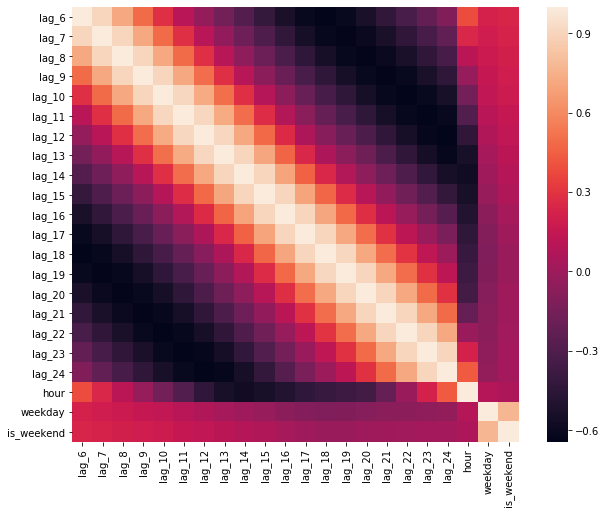

In [43]:
plt.figure(figsize=(10,8))
sns.heatmap(X_train.corr())
plt.show();

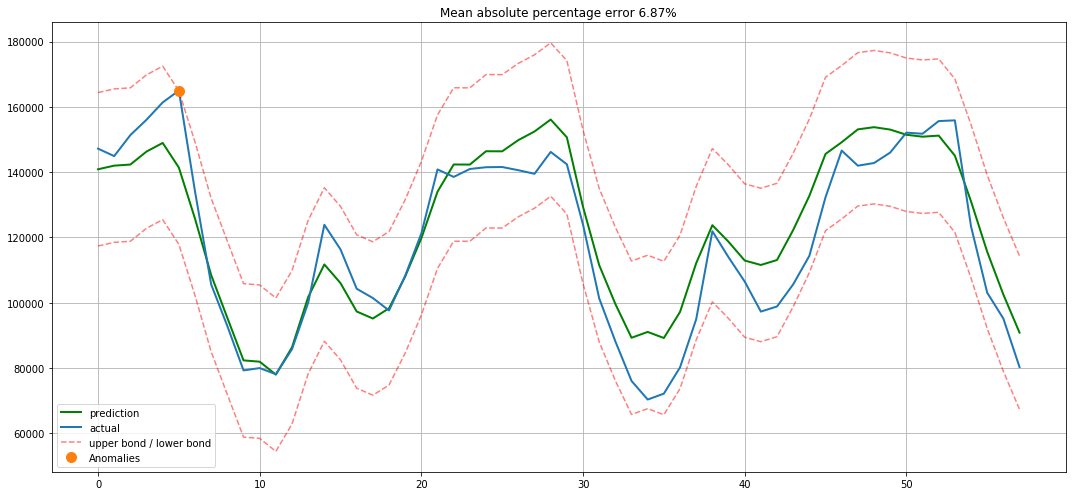

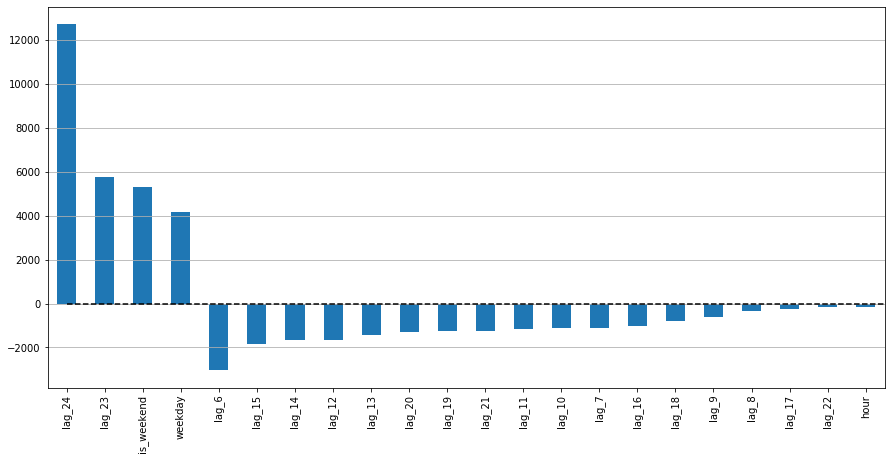

In [44]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge,
                X_train = X_train_scaled,
                X_test = X_test_scaled,
                plot_intervals=True,
                plot_anomalies=True)

plotCoefficients(ridge)

We can see how coefficients are getting close and cloes to Zero. As their importance in the model drops

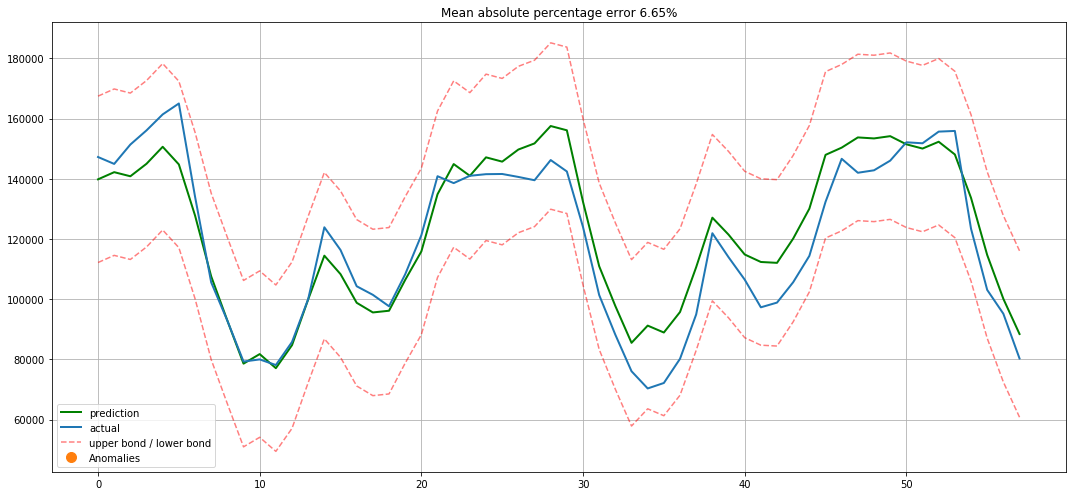

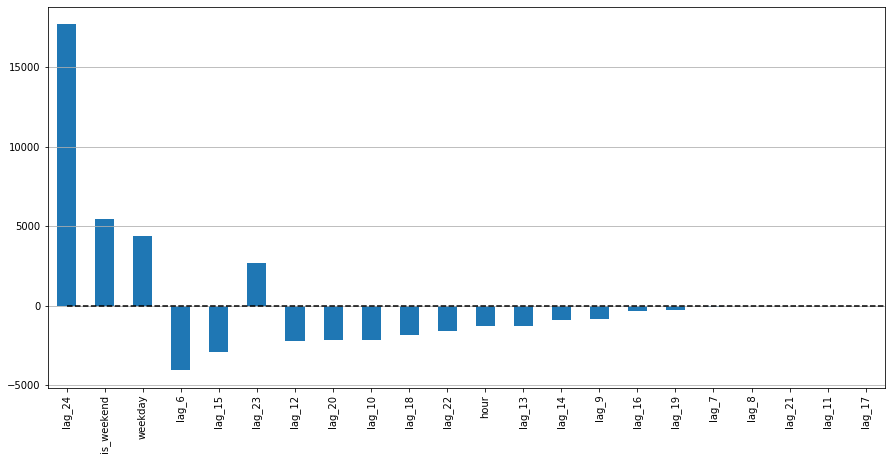

In [45]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso,
                X_train = X_train_scaled,
                X_test = X_test_scaled,
                plot_intervals=True,
                plot_anomalies=True)

plotCoefficients(lasso)

Lasso regression turned out to be more conservative and removed 23-rd lag from most important features and also dropped 5 features completely. Which made the quality of the model better.

# XGBoost

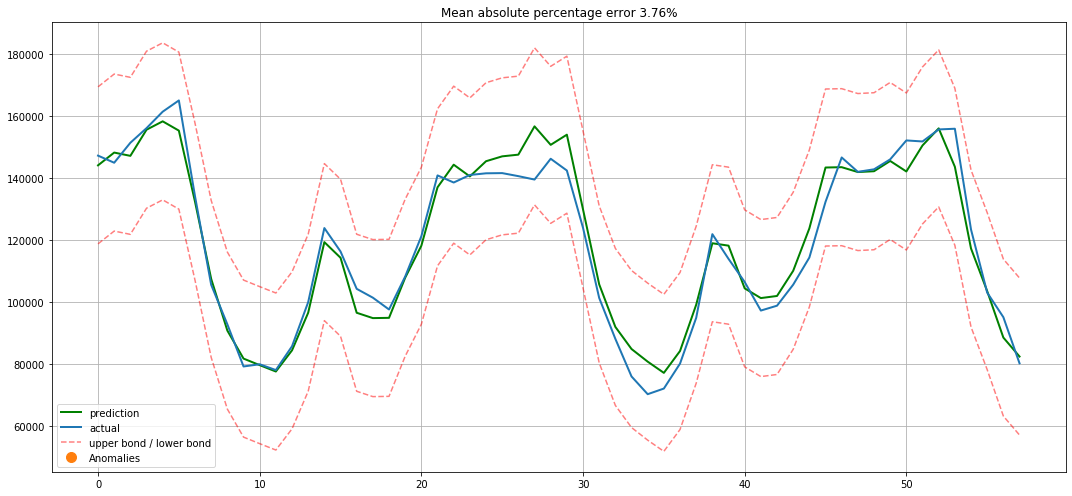

In [53]:
from xgboost import XGBRegressor

xgb = XGBRegressor(objective ='reg:squarederror')
xgb.fit(X_train_scaled, y_train)

plotModelResults(xgb,
                X_train=X_train_scaled,
                X_test=X_test_scaled,
                plot_intervals=True,
                plot_anomalies=True)

This is the winner. Smallest Error.
Generally tree-based models poorly handle trends in data compared to linear models. So you have to detrend your series first or use some tricks. Ideally - make the series tsationary and then use XGBoost, for example, you can forecast rend separately with a linear model then add predictions from XGBoost to get the final forecast.

In [47]:

X_train, X_test, y_train, y_test =\
prepareData(ads.Ads, lag_start=6, lag_end=25, test_size=0.3, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## top 5

In [ ]:
idf = pd.read_csv('./Data/inventory_split.csv')

In [ ]:
import datetime as dt
idf['Document date'] = pd.to_datetime(idf['Document date'])
idf['cw-'] = (idf['Document date'] - pd.to_datetime('today')).apply(lambda x: x.days)//7

In [ ]:
top5_ = idf.pivot_table(values ='Order qty', index = ['Description'],aggfunc = lambda x: x.sum()).sort_values(by = 'Order qty', ascending = False).index[:5]
temp = pd.DataFrame(idf[idf['Description'].isin([top5_[0]])].pivot_table(values='Order qty', index = ['cw-'], columns = 'Plant',aggfunc = lambda x: x.sum()).fillna(0)['USJ7'])

In [ ]:
plt.figure(figsize = (15,7))
plt.plot(temp)
plt.grid(True)
plt.show()

plotMovingAverage(temp,4) # per Month
plotMovingAverage(temp, 4, plot_intervals = True)
plotMovingAverage(temp, 4, plot_intervals=True, plot_anomalies = True)


In [ ]:
idf[idf['cw-'].isin([-58,-39,-36])]['Document date'].unique()

In [ ]:
ads.Ads

In [ ]:
plotExponentialSmoothing(temp['USJ7'], [0.3,0.05])

In [ ]:
plotDoubleExponentialSmoothing(temp['USJ7'], alphas = [0.8, 0.05], betas=[0.8,0.05])